# Variational AutoEncoders

Full Name:ahmadreza majlesara

Student ID:400101861


# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and a conditional variational autoencoder with slightly different architectures and apply them to the popular MNIST handwritten dataset.

Load several useful packages that are used in this notebook:

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import random
import cv2
import matplotlib as mpl
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [2]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load MNIST Dataset


VAEs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which has 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset.

In [7]:
batch_size = 128

mnist_train = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



## Visualize dataset

It is always a good idea to look at examples from the dataset before working with it. Let's visualize the digits in the MNIST dataset. We have defined the function `show_images` to visualize the images.


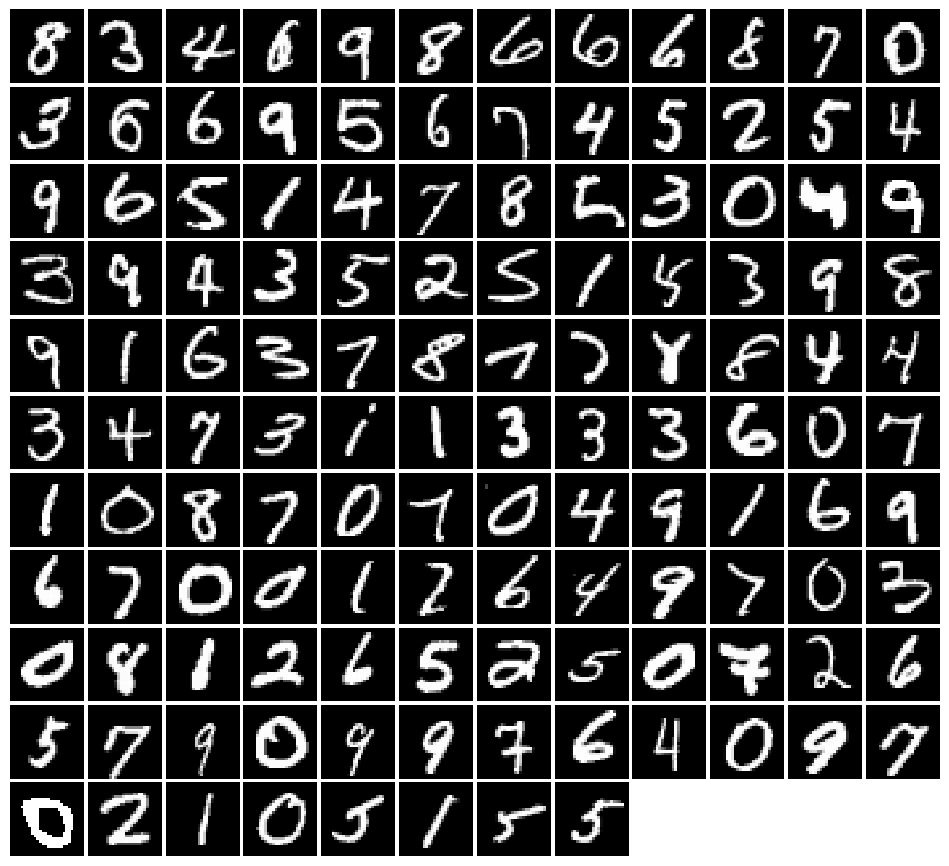

In [4]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

data_iter = iter(loader_train)
imgs, _ = next(data_iter)
imgs = imgs.view(batch_size, 784)
show_images(imgs)

# Fully Connected VAE

Your first VAE implementation will consist solely of fully connected layers. You'll take the `1 x 28 x 28` shape of our input and flatten the features to create an input dimension size of 784. In this section you'll define the Encoder and Decoder models in the VAE class and implement the reparametrization trick, forward pass, and loss function to train your first VAE.

## FC-VAE Forward

Complete the VAE class by writing the initialization and the forward pass. The forward pass should pass the input image through the encoder to calculate the estimation of mu and logvar, reparametrize to estimate the latent space z, and finally pass z into the decoder to generate an image.



In [3]:
# Define a simple VAE class with MLP architecture
class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device):
        super(VAE_MLP, self).__init__()
        self.device = device

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Latent space transformation
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),  # Ensures output is between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)  # Sample from standard normal distribution
        return mu + eps * std  # Reparametrize

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar


## Loss Function

Complete the vae_loss function below

In [4]:
# Define VAE loss function
def vae_loss(recon, data, mu, logvar):
    # Reconstruction Loss (Binary Cross Entropy)
    recon_loss = F.binary_cross_entropy(recon, data.view(-1, 784), reduction="sum")

    # KL Divergence Loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total Loss
    return recon_loss + kl_loss



## Train a model

Now that we have our VAE defined and loss function ready, lets train our model!

Complete the train_vae_mlp function to train the network.

In [5]:
def train_vae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        print("\n" + "=" * 45)
        total_loss = []

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)  # Move data to GPU if available

            # Forward pass
            recon, mu, logvar = model(data)

            # Flatten input and output tensors
            data = data.view(data.size(0), -1)
            recon = recon.view(recon.size(0), -1)

            # Compute loss
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())

        # Compute average loss for the epoch
        avg_loss = float(sum(total_loss) / len(total_loss))
        print(f'VAE- Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


In [8]:
# Define the latent space size
latent_size = 20  # Can be adjusted based on experiment

# Define model parameters
input_dim = 784  # 28x28 flattened
hidden_dim = 400  # Hidden layer size (can be adjusted)
latent_dim = latent_size  # Latent space size

# Instantiate VAE model
VAE = VAE_MLP(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, device=device)

# Train the model
train_vae_mlp(VAE, loader_train, num_epochs=20, learning_rate=1e-3)



VAE- Epoch [1/20], Loss: 22521.2889

VAE- Epoch [2/20], Loss: 16273.4470

VAE- Epoch [3/20], Loss: 14950.9045

VAE- Epoch [4/20], Loss: 14374.6208

VAE- Epoch [5/20], Loss: 14036.2003

VAE- Epoch [6/20], Loss: 13815.9538

VAE- Epoch [7/20], Loss: 13651.2634

VAE- Epoch [8/20], Loss: 13510.7585

VAE- Epoch [9/20], Loss: 13408.0780

VAE- Epoch [10/20], Loss: 13311.1925

VAE- Epoch [11/20], Loss: 13225.1393

VAE- Epoch [12/20], Loss: 13145.8212

VAE- Epoch [13/20], Loss: 13077.1859

VAE- Epoch [14/20], Loss: 13023.7623

VAE- Epoch [15/20], Loss: 12965.4442

VAE- Epoch [16/20], Loss: 12925.7340

VAE- Epoch [17/20], Loss: 12885.5659

VAE- Epoch [18/20], Loss: 12849.3054

VAE- Epoch [19/20], Loss: 12817.6555

VAE- Epoch [20/20], Loss: 12790.1734


## Visualize results

After training our VAE network, we're able to take advantage of its power to generate new training examples. This process simply involves the decoder: we intialize some random distribution for our latent spaces z, and generate new examples by passing these latent space into the decoder.

Run the cell below to generate new images! You should be able to visually recognize many of the digits, although some may be a bit blurry or badly formed. Our next model will see improvement in these results.

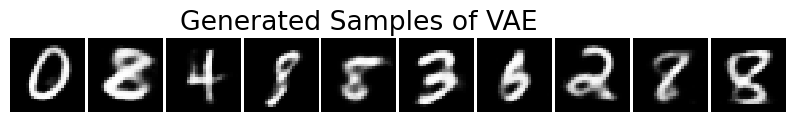

In [9]:
num_samples = 10
z = torch.randn(num_samples, latent_size).to(device=device)

VAE.eval()
samples = VAE.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    if i == 4:
      plt.title('Generated Samples of VAE')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28), cmap='Greys_r')

# Conditional FC-VAE

The second model you'll develop will be very similar to the FC-VAE, but with a slight conditional twist to it. We'll use what we know about the labels of each MNIST image, and *condition* our latent space and image generation on the specific class. Instead of $q_{\phi} (z|x)$ and $p_{\phi}(x|z)$ we have $q_{\phi} (z|x,c)$  and $p_{\phi}(x|z, c)$

This will allow us to do some powerful conditional generation at inference time. We can specifically choose to generate more 1s, 2s, 9s, etc. instead of simply generating new digits randomly.

## Define Network with class input

Your CVAE architecture should be the same as your FC-VAE architecture, except you'll now concatenate a one-hot label vector to both the x input (in our case, the flattened image dimensions) and the z latent space.

If the one-hot vector is called `c`, then `c[label] = 1` and `c = 0` elsewhere.

For the `CVAE_MLP` class use the same FC-VAE architecture implemented in the last network.


In [10]:
# Define a simple CVAE class with MLP architecture
class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, device):
        super(CVAE_MLP, self).__init__()
        self.device = device
        self.num_classes = num_classes

        # Adjust input size to include class label (one-hot vector)
        self.input_dim = input_dim + num_classes  # Concatenating input + label

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Latent space transformation
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder input size: latent_dim + num_classes (since z is conditioned on class label)
        self.decoder_input_dim = latent_dim + num_classes

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.decoder_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),  # Normalize output to [0,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)  # Sample from standard normal distribution
        return mu + eps * std  # Apply the reparameterization trick

    def forward(self, x, y):
        x = x.view(x.size(0), -1)  # Flatten input
        y = F.one_hot(y, num_classes=self.num_classes).float()  # Convert label to one-hot
        y = y.view(y.size(0), -1)  # Flatten label

        # Concatenate image with label
        input_with_label = torch.cat((x, y), dim=1)

        # Encoder forward pass
        encoded = self.encoder(input_with_label)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)

        # Sample latent vector
        z = self.reparameterize(mu, logvar)

        # Concatenate latent vector with label
        z_with_label = torch.cat((z, y), dim=1)

        # Decoder forward pass
        decoded = self.decoder(z_with_label)

        return decoded, mu, logvar


If you want to build helper functions, you can write the code in the below cell.

# Loss Function

Complete the cvae_loss function below

In [11]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits=None, labels=None):
    # Flatten input images and reconstructions
    data = data.view(data.size(0), -1)
    recon = recon.view(recon.size(0), -1)

    # Reconstruction Loss (Binary Cross Entropy)
    recon_loss = F.binary_cross_entropy(recon, data, reduction="sum")

    # KL Divergence Loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Optional: Class Prediction Loss (if class_logits are provided)
    if class_logits is not None and labels is not None:
        class_loss = F.cross_entropy(class_logits, labels, reduction="sum")
    else:
        class_loss = 0  # No classification loss in a standard CVAE

    # Total Loss
    return recon_loss + kl_loss + class_loss


## Train model

Using the same training script, let's now train our CVAE!



In [12]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        print("\n" + "=" * 45)
        total_loss = []

        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)  # Move data to GPU if available

            # One-hot encode the labels
            one_hot_labels = F.one_hot(labels, num_classes=model.num_classes).float()

            # Forward pass through the model
            recon, mu, logvar = model(data, labels)

            # Compute loss using cvae_loss function
            loss = cvae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())

        # Compute average loss for the epoch
        avg_loss = float(sum(total_loss) / len(total_loss))
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


In [13]:
# Define the latent space size
latent_size = 20  # Can be adjusted (e.g., 10, 50, etc.)

# Define model parameters
input_dim = 784  # MNIST images are 28x28 (flattened)
hidden_dim = 400  # Hidden layer size (adjustable)
latent_dim = latent_size  # Latent space dimension
num_classes = 10  # MNIST digits (0-9)

# Instantiate CVAE model
CVAE = CVAE_MLP(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, num_classes=num_classes, device=device)

# Train the model
train_cvae_mlp(CVAE, loader_train, num_epochs=20, learning_rate=1e-3)



CVAE-MLP Epoch [1/20], Loss: 21571.8432

CVAE-MLP Epoch [2/20], Loss: 15746.5330

CVAE-MLP Epoch [3/20], Loss: 14591.1236

CVAE-MLP Epoch [4/20], Loss: 13949.0286

CVAE-MLP Epoch [5/20], Loss: 13537.0736

CVAE-MLP Epoch [6/20], Loss: 13260.3278

CVAE-MLP Epoch [7/20], Loss: 13068.5975

CVAE-MLP Epoch [8/20], Loss: 12925.8170

CVAE-MLP Epoch [9/20], Loss: 12805.9844

CVAE-MLP Epoch [10/20], Loss: 12709.6647

CVAE-MLP Epoch [11/20], Loss: 12631.7688

CVAE-MLP Epoch [12/20], Loss: 12558.3104

CVAE-MLP Epoch [13/20], Loss: 12499.7622

CVAE-MLP Epoch [14/20], Loss: 12444.3697

CVAE-MLP Epoch [15/20], Loss: 12397.1551

CVAE-MLP Epoch [16/20], Loss: 12352.7725

CVAE-MLP Epoch [17/20], Loss: 12318.1083

CVAE-MLP Epoch [18/20], Loss: 12281.4460

CVAE-MLP Epoch [19/20], Loss: 12244.9241

CVAE-MLP Epoch [20/20], Loss: 12214.7873


## Visualize Results

You've trained your CVAE, now let's conditionally generate some new data! This time, we can specify the class we want to generate by adding our one hot matrix of class labels. We use `torch.eye` to create an identity matrix, which effectively gives us one label for each digit. When you run the cell below, you should get one example per digit. Each digit should be reasonably distinguishable (it is ok to run this cell a few times to save your best results).



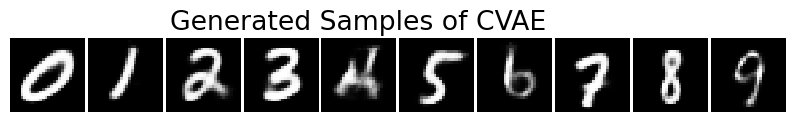

In [16]:
num_samples = 10
z = torch.randn(num_samples, latent_size)

c = torch.eye(num_samples, 10)

z = torch.cat((z,c), dim=-1).to(device='cuda')
CVAE.eval()
samples = CVAE.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    if i == 4:
      plt.title('Generated Samples of CVAE')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')